In [1]:
%pip install catboost optuna optuna-integration[catboost]

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

In [3]:
import os
from pathlib import Path

IN_COLAB = "COLAB_GPU" in os.environ or "google.colab" in str(get_ipython())

if not IN_COLAB:
    ROOT = Path.cwd()

    if ROOT.name == "lab02":
        LAB_ROOT = ROOT
    elif (ROOT / "lab02").exists():
        LAB_ROOT = ROOT / "lab02"
    elif ROOT.name == "notebooks":
        LAB_ROOT = ROOT.parent
    else:
        raise FileNotFoundError("Не нашёл папку lab02 от текущей директории.")

    DATA_RAW = LAB_ROOT / "data" / "raw"
    DATA_RAW.mkdir(parents=True, exist_ok=True)

    csv_path = DATA_RAW / "telco.csv"

else:
    from urllib.request import urlretrieve

    url = "https://raw.githubusercontent.com/OlegTertychnyi/ML-labs-Tert/main/lab03/data/raw/telco.csv"
    csv_path = Path("/content/telco.csv")

    if not csv_path.exists():
        urlretrieve(url, csv_path)
        print("✔ Dataset downloaded to Colab")

csv_path


PosixPath('/home/optert/ML-labs-Tert/lab03/data/raw/telco.csv')

In [4]:
X = pd.read_csv(csv_path)
X

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
y = X.pop('Churn')

# Переводим TotalCharges и SeniorCitizen в нужные типы
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X['TotalCharges'] = X['TotalCharges'].fillna(X['TotalCharges'].mean())
X['SeniorCitizen'] = X['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [6]:
# Добавляем в датасет 5 фичей: 2 PCA, 2 а-ля RFM фичи, 1 флаг
pca = PCA(n_components=2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['tenure', 'MonthlyCharges', 'TotalCharges']])
pca.fit(X_scaled)
X['PC1'] = pca.transform(X_scaled)[:, 0]
X['PC2'] = pca.transform(X_scaled)[:, 1]
X['tenure_norm_by_contract_type'] = (
    X['tenure'] - X.groupby('Contract')['tenure'].transform('mean')
) / X.groupby('Contract')['tenure'].transform('std')
X['tenure_norm_by_payment_method'] = (
    X['tenure'] - X.groupby('PaymentMethod')['tenure'].transform('mean')
) / X.groupby('PaymentMethod')['tenure'].transform('std')
X['MonthlyCharges_small_flag'] = X['MonthlyCharges'].apply(lambda x: 'Yes' if x < 30 else 'No')

In [7]:
# Разделяем фичи
sku = ['customerID']
numeric = ['tenure', 'MonthlyCharges', 'TotalCharges', 'PC1', 'PC2', 'tenure_norm_by_contract_type', 'tenure_norm_by_payment_method']
categorical = X.columns.drop(numeric + sku).tolist()
binary = X.columns[X.nunique() == 2].tolist()
for cat in binary:
    if cat in categorical:
        categorical.remove(cat)

# Переведем метки в 1/0
le_churn = LabelEncoder()
y = le_churn.fit_transform(y)

In [8]:
# Логика предобработки фичей
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Общий для всех моделей препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numeric),
    ('cat', categorical_transformer, categorical),
    ('bin', binary_transformer, binary)
])

# Делим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7),
    'Random Forest': RandomForestClassifier(n_estimators=500)
}

In [9]:
# Определяем пайплайны и
pipelines = {name: Pipeline([('preprocessor', preprocessor), ('model', model)]) for name, model in models.items()}

results = []

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)

    y_score = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_score)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc
    })

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.819730,0.681957,0.597855,0.637143,0.862889
1,Support Vector Machine,0.809794,0.690909,0.509383,0.586420,0.803794
2,K-Nearest Neighbors,0.789922,0.609687,0.573727,0.591160,0.822641
3,Random Forest,0.798439,0.659498,0.493298,0.564417,0.839590


In [10]:
cb_preprocessor = ColumnTransformer(transformers=[
        ('num', 'passthrough', numeric),
        ('cat', 'passthrough', categorical),
        ('bin', 'passthrough', binary)
    ],
    remainder='drop'
)

cat_idx = list(range(len(numeric), len(numeric) + len(categorical) + len(binary)))

cb_model = CatBoostClassifier(
    n_estimators=500,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    cat_features=cat_idx
)

cb_pipeline = Pipeline(steps=[
    ('preprocessor', cb_preprocessor),
    ('model', cb_model)
])

cb_pipeline.fit(X_train, y_train)

y_pred = cb_pipeline.predict(X_test)
y_score = cb_pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)

results.append({
    'Model': 'Catboost Classifier',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc
})

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.819730,0.681957,0.597855,0.637143,0.862889
1,Support Vector Machine,0.809794,0.690909,0.509383,0.586420,0.803794
2,K-Nearest Neighbors,0.789922,0.609687,0.573727,0.591160,0.822641
3,Random Forest,0.798439,0.659498,0.493298,0.564417,0.839590
4,Catboost Classifier,0.808375,0.678201,0.525469,0.592145,0.860484


In [11]:
def make_logreg_pipeline(C, penalty, l1_ratio, solver):
    # согласуем penalty/solver
    params = dict(C=C, max_iter=5000, random_state=42)
    if penalty == "l1":
        params.update(penalty="l1", solver="liblinear")
    elif penalty == "l2":
        params.update(penalty="l2", solver="lbfgs")
    else:  # elasticnet
        params.update(penalty="elasticnet", solver="saga", l1_ratio=l1_ratio)

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(**params))
    ])
    return pipe

def objective_logreg(trial: optuna.Trial) -> float:
    # поиск по осмысленному пространству
    penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    l1_ratio = 0.0
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    # solver задаём внутри конструктора согласно penalty

    pipe = make_logreg_pipeline(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=None)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # важо: оптимизируем ROC-AUC на CV
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    return float(scores.mean())

study_lr = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_lr.optimize(objective_logreg, n_trials=30, show_progress_bar=True)

best_params_lr = study_lr.best_params
best_value_lr = study_lr.best_value
print("Best LR AUC:", best_value_lr)
print("Best LR params:", best_params_lr)

[I 2025-11-13 23:18:22,365] A new study created in memory with name: no-name-5279d10e-3629-42d5-a0ea-3403f5605c47


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-13 23:18:26,480] Trial 0 finished with value: 0.8401993410986949 and parameters: {'penalty': 'l1', 'C': 0.9846738873614566}. Best is trial 0 with value: 0.8401993410986949.
[I 2025-11-13 23:18:29,019] Trial 1 finished with value: 0.8411111373685417 and parameters: {'penalty': 'l2', 'C': 21.42302175774105}. Best is trial 1 with value: 0.8411111373685417.
[I 2025-11-13 23:18:35,351] Trial 2 finished with value: 0.8414809232636165 and parameters: {'penalty': 'l1', 'C': 70.72114131472235}. Best is trial 2 with value: 0.8414809232636165.
[I 2025-11-13 23:18:38,409] Trial 3 finished with value: 0.8369467663612854 and parameters: {'penalty': 'l2', 'C': 0.008260808399079604}. Best is trial 2 with value: 0.8414809232636165.
[I 2025-11-13 23:18:40,615] Trial 4 finished with value: 0.8339128952722579 and parameters: {'penalty': 'l1', 'C': 0.028585493941961918}. Best is trial 2 with value: 0.8414809232636165.
[I 2025-11-13 23:18:40,860] Trial 5 finished with value: 0.8394151689137184 an

In [12]:
best_lr_pipe = make_logreg_pipeline(
    C=best_params_lr["C"],
    penalty=best_params_lr["penalty"],
    l1_ratio=best_params_lr.get("l1_ratio", 0.0),
    solver=None
)

best_lr_pipe.fit(X_train, y_train)

y_score = best_lr_pipe.predict_proba(X_test)[:, 1]
y_pred = best_lr_pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_score)

results.append({
    'Model': 'Tuned LR',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc
})


In [13]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.819730,0.681957,0.597855,0.637143,0.862889
1,Support Vector Machine,0.809794,0.690909,0.509383,0.586420,0.803794
2,K-Nearest Neighbors,0.789922,0.609687,0.573727,0.591160,0.822641
3,Random Forest,0.798439,0.659498,0.493298,0.564417,0.839590
4,Catboost Classifier,0.808375,0.678201,0.525469,0.592145,0.860484
5,Tuned LR,0.819730,0.685358,0.589812,0.634006,0.862227


In [16]:
cb_preprocessor = ColumnTransformer(transformers=[
        ('num', 'passthrough', numeric),
        ('cat', 'passthrough', categorical),
        ('bin', 'passthrough', binary)
    ],
    remainder='drop'
)

cat_idx = list(range(len(numeric), len(numeric) + len(categorical) + len(binary)))


def objective_cb(trial: optuna.Trial) -> float:
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
            "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        oof_scores = []

        for train_idx, valid_idx in cv.split(X_train, y_train):
            X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr, y_va = y_train[train_idx], y_train[valid_idx]

            pre = cb_preprocessor
            pre.fit(X_tr, y_tr)

            X_tr_t = pre.transform(X_tr)
            X_va_t = pre.transform(X_va)

            model = CatBoostClassifier(
                loss_function="Logloss",
                eval_metric="AUC",
                random_seed=42,
                verbose=False,
                cat_features=cat_idx,
                **params
            )

            model.fit(
                X_tr_t, y_tr,
                eval_set=(X_va_t, y_va),
                early_stopping_rounds=100
            )


            y_va_proba = model.predict_proba(X_va_t)[:, 1]
            oof_scores.append(roc_auc_score(y_va, y_va_proba))

            trial.report(float(np.mean(oof_scores)), step=len(oof_scores))
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(oof_scores))


study_cb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10)
)
study_cb.optimize(objective_cb, n_trials=25, show_progress_bar=True)

print("Best CB AUC (CV):", study_cb.best_value)
print("Best CB params:", study_cb.best_params)

[I 2025-11-13 23:25:19,658] A new study created in memory with name: no-name-dccdab17-dab2-4cc3-93df-e360e523db38


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-13 23:25:59,756] Trial 0 finished with value: 0.8409172321049994 and parameters: {'learning_rate': 0.030710573677773714, 'depth': 10, 'l2_leaf_reg': 7.587945476302646, 'n_estimators': 2117, 'colsample_bylevel': 0.6624074561769746}. Best is trial 0 with value: 0.8409172321049994.
[I 2025-11-13 23:27:07,841] Trial 1 finished with value: 0.8456409217639734 and parameters: {'learning_rate': 0.015957084694148364, 'depth': 4, 'l2_leaf_reg': 8.795585311974417, 'n_estimators': 2123, 'colsample_bylevel': 0.8832290311184181}. Best is trial 1 with value: 0.8456409217639734.
[I 2025-11-13 23:28:06,753] Trial 2 finished with value: 0.8410401373935683 and parameters: {'learning_rate': 0.010636066512540286, 'depth': 10, 'l2_leaf_reg': 8.491983767203795, 'n_estimators': 1267, 'colsample_bylevel': 0.6727299868828402}. Best is trial 1 with value: 0.8456409217639734.
[I 2025-11-13 23:28:55,101] Trial 3 finished with value: 0.8451706632175657 and parameters: {'learning_rate': 0.0173226674705462

In [17]:
pre = cb_preprocessor
pre.fit(X_train, y_train)

X_train_t = pre.transform(X_train)
X_test_t = pre.transform(X_test)

best_cb_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
    cat_features=cat_idx,
    **study_cb.best_params
)

best_cb_model.fit(
    X_train_t, y_train,
    eval_set=(X_test_t, y_test),
    early_stopping_rounds=100
)

y_scores = best_cb_model.predict_proba(X_test_t)[:, 1]
y_pred  = best_cb_model.predict(X_test_t)

results_catboost = {
    "Model": "Tuned CatBoost",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_scores),
}

results.append(results_catboost)

In [18]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.819730,0.681957,0.597855,0.637143,0.862889
1,Support Vector Machine,0.809794,0.690909,0.509383,0.586420,0.803794
2,K-Nearest Neighbors,0.789922,0.609687,0.573727,0.591160,0.822641
3,Random Forest,0.798439,0.659498,0.493298,0.564417,0.839590
4,Catboost Classifier,0.808375,0.678201,0.525469,0.592145,0.860484
5,Tuned LR,0.819730,0.685358,0.589812,0.634006,0.862227
6,Tuned CatBoost,0.815472,0.690236,0.549598,0.611940,0.867366


In [25]:
def optimize_treshold(trial: optuna.Trial) -> float:
    threshold = trial.suggest_float('threshold', 0.2, 0.9)
    y_pred = (y_scores >= threshold).astype(int)
    return f1_score(y_test, y_pred) + 0.5 * precision_score(y_test, y_pred) + 0.5 * recall_score(y_test, y_pred)

study_treshold = optuna.create_study(
    direction='maximize'
)

study_treshold.optimize(optimize_treshold, n_trials=100)

study_treshold.best_params

[I 2025-11-13 23:39:39,868] A new study created in memory with name: no-name-cd322a1e-ed5e-4871-80ce-a9965fc255d4
[I 2025-11-13 23:39:39,874] Trial 0 finished with value: 1.2297869751039139 and parameters: {'threshold': 0.4991192553221867}. Best is trial 0 with value: 1.2297869751039139.
[I 2025-11-13 23:39:39,879] Trial 1 finished with value: 0.90830949141691 and parameters: {'threshold': 0.726191052806308}. Best is trial 0 with value: 1.2297869751039139.
[I 2025-11-13 23:39:39,885] Trial 2 finished with value: 0.7575159382242889 and parameters: {'threshold': 0.778328239299604}. Best is trial 0 with value: 1.2297869751039139.
[I 2025-11-13 23:39:39,891] Trial 3 finished with value: 0.9975887541201124 and parameters: {'threshold': 0.6537597315056066}. Best is trial 0 with value: 1.2297869751039139.
[I 2025-11-13 23:39:39,897] Trial 4 finished with value: 1.291653660420274 and parameters: {'threshold': 0.42843030531976223}. Best is trial 4 with value: 1.291653660420274.
[I 2025-11-13 23

{'threshold': 0.328271855420714}

In [26]:
threshold = study_treshold.best_params['threshold']
y_pred = (y_scores >= threshold).astype(int)
results_catboost = {
    "Model": "Tuned CatBoost and f1 tuned threshold",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_scores),
}
results.append(results_catboost)
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.819730,0.681957,0.597855,0.637143,0.862889
1,Support Vector Machine,0.809794,0.690909,0.509383,0.586420,0.803794
2,K-Nearest Neighbors,0.789922,0.609687,0.573727,0.591160,0.822641
3,Random Forest,0.798439,0.659498,0.493298,0.564417,0.839590
4,Catboost Classifier,0.808375,0.678201,0.525469,0.592145,0.860484
5,Tuned LR,0.819730,0.685358,0.589812,0.634006,0.862227
6,Tuned CatBoost,0.815472,0.690236,0.549598,0.611940,0.867366
7,Tuned CatBoost and f1 tuned threshold,0.805536,0.603340,0.774799,0.678404,0.867366


In [27]:
fi = pd.DataFrame({
    'Feature':  pre.get_feature_names_out(),
    'Best cb importance': best_cb_model.get_feature_importance(),
    'Baseline cb importance': cb_pipeline.named_steps['model'].get_feature_importance()
})

In [28]:
fi.head()

,Feature,Best cb importance,Baseline cb importance
0,num__tenure,12.142158,6.387830
1,num__MonthlyCharges,6.200190,6.135303
2,num__TotalCharges,4.312004,5.167690
3,num__PC1,1.966166,4.965845
4,num__PC2,18.238716,9.625724


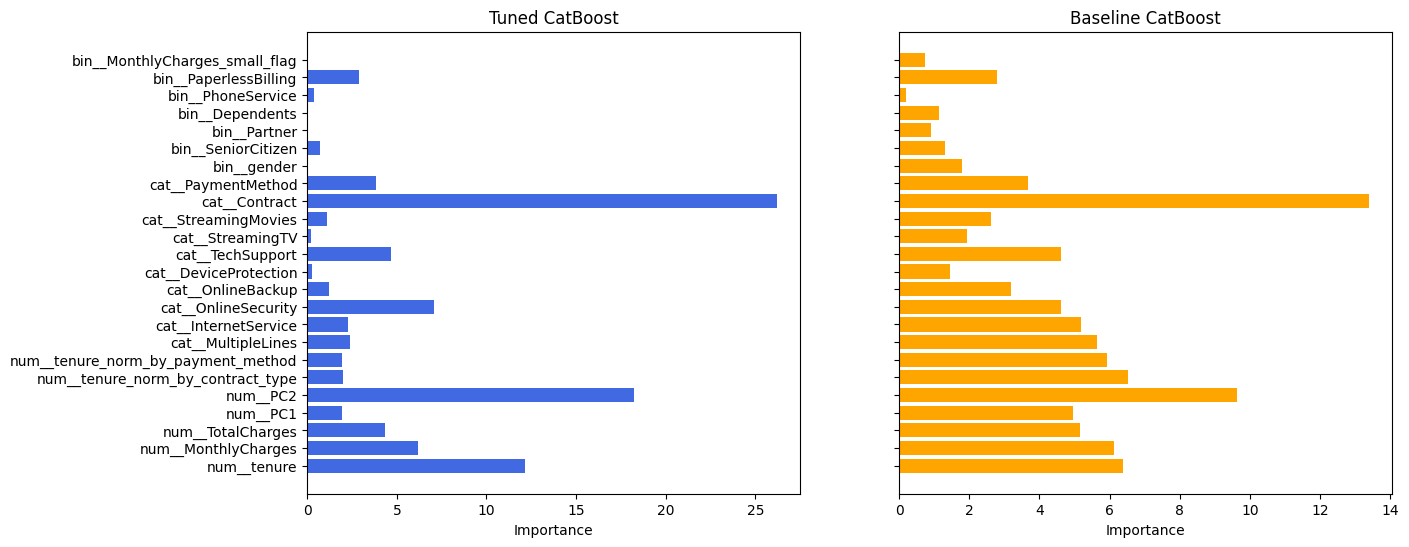

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].barh(fi["Feature"], fi["Best cb importance"], color="royalblue")
axes[0].set_title("Tuned CatBoost")
axes[0].set_xlabel("Importance")

axes[1].barh(fi["Feature"], fi["Baseline cb importance"], color="orange")
axes[1].set_title("Baseline CatBoost")
axes[1].set_xlabel("Importance")
plt.show()